# Simulation Methods Project

Adapted from Maciej Workiewicz

Authors:
* Pauline Engel
* Sebastian Erhardt
* Saskia Hasreiter
* Leo Schwarze
* Felix Siegel


In [1]:
import os
from time import time
import matplotlib.pyplot as plt
import random
import numpy as np
import itertools
import csv
import json
import pandas as pd

In [2]:
AMOUNT_OF_ITERATIONS= 1000  # we will generate 1000 NK landscapes to begin with

## Interaction Matrix

In [3]:
def generate_random_interaction_matrix(N: int, K: int):
    '''
    This function takes the number of N elements and K interdependencies
    and creates a random N x N interaction matrix.
    All elements on the diagonal [0,0],[1,1],...[N-1,N-1] will be 1s.
    Based on the K, there will be additional K 1 in each row in addition to the diagonal.
    '''
    Int_matrix_rand = np.zeros((N, N)) # generate a N x N Matrix
    for aa1 in np.arange(N): # iterate over the indexes from 0,1,... to N
        Indexes_1 = list(range(N)) # generate a list from 0,1,... to N
        Indexes_1.remove(aa1)  # remove aa1 index e.g. remove 2 from the list
        np.random.shuffle(Indexes_1) # shuffle the indexes
        Indexes_1.append(aa1) # add the removed index again at the end
        Chosen_ones = Indexes_1[-(K+1):]  # extract the last K indexes in the shuffled 
        for aa2 in Chosen_ones: # iterate over the extracted indexes
            Int_matrix_rand[aa1, aa2] = 1  # set the poistion to 1 in the result matrix
    return(Int_matrix_rand)

## Calculate Coefficient

In [4]:
def calculate_coefficient(position, N:int, C:float):
    # sum of 1s in the position vector
    sum_of_ones = np.sum(position) 
    # get the max amount of the same values
    same_values = max(sum_of_ones, N-sum_of_ones)
    # calculate the coefficient
    coefficient = (1+((same_values/N)-0.5))**(same_values-(N/2))    
    # multiply the coefficient with the fitness factor
    result = coefficient * C    
    return result

## Fitness Calculation

In [5]:
def calculate_fitness_vector(landscape, interaction_matrix, position, power_key, N, C):
    '''
    Takes the landscape, an interaction matrix and a given combination and returns a vector of fitness
    values for the vector of the N decision variables.
    ''' 
    # calculate the coefficient by providing the positionm, N and C
    coefficient = calculate_coefficient(position, N, C)
    # initialize the fitness vector with length N and 0
    result = np.zeros(N) 
    for y in np.arange(N):
        x = np.sum(position * interaction_matrix[y] * power_key)  
        # calculate the percieved fitness
        percieved_fitness = landscape[x, y] + coefficient      
        result[y] = percieved_fitness
    return(result)

## Calc Values for Landscapes

In [6]:
def generate_landscape(N:int, K:int, C:float, power_key):
    """
    Calculates values for all positions on the landscape. The resulting
    array contains:
    - the first columns indexed from 0 to N-1 are for each of the combinations
    - columns indexed from N to 2*N-1 are for the fit value (vector) of those combinations
    - the column indexed 2N is for the total fit (average of the entire vector)
    - column indexed 2N+1 is a dummy, with 1 indicating a local peak
    - the last column is a dummy, with 1 indicating the global peak
    """
    # generate a random interaction matrix
    interaction_matrix = generate_random_interaction_matrix(N, K).astype(int)
    # generate a random 2^N x N matrix
    # in every cell there is a random value between 0 and 1
    random_landscape = np.random.rand(2**N, N)  # this is a table of random U(0,1) numbers
    
    # inizialize a result matrix 
    # with the dimensions 2^N and N*2+3
    # the + 3 store the:
    # - the mean of the fitness vector
    # - if the position is a lokal peak
    # - if the position is a global peak
    result = np.zeros((2**N, N*2+3))  # to capture the results
    position_counter = 0  # starting counter for location
    
    # iterate over all possible representations of a list of the lenth of N
    # filled with 0s and 1s
    # starting with [0,0,0,0,..]
    # ending with [1,1,1,1,..]
    # so in the end there are 2^N combinations
    # imagine these combination as the position in the landscape
    for i in range(2**N):
        position = np.array(list(np.binary_repr(i).zfill(N))).astype(int) # taking each position
        
        # now calculate the fitness vector
        fit_1 = calculate_fitness_vector(random_landscape, interaction_matrix, position, power_key, N, C)
        
        result[position_counter, :N] = position  # store the position in the matrix
        result[position_counter, N:2*N] = fit_1
        result[position_counter, 2*N] = np.mean(fit_1)
        position_counter = position_counter + 1
    

    # look for the peaks    
    for c3 in np.arange(2**N):  # now let's see if it is a local peak
        loc_p = 1  # first, assume it is
        for c4 in np.arange(N):  # check the local neighbourhood
            new_comb = result[c3, :N].copy().astype(int)
            new_comb[c4] = abs(new_comb[c4] - 1)
            if ((result[c3, 2*N] <
                 result[np.sum(new_comb*power_key), 2*N])):
                loc_p = 0  # if smaller than the neighbour, then it is not peak
        result[c3, 2*N+1] = loc_p
    
    # store the global peak
    max_ind = np.argmax(result[:, 2*N]) # get the max result from the local peaks
    result[max_ind, 2*N+2] = 1 # set the global peak to 1
    return(result)

## Generate Landscapes

In [7]:
def generate_landscapes(N:int, K:int, C:float, power_key):
    # init empty landscapes tensor
    # Iterations
    # Landscape
    # Results
    landscapes = np.zeros((AMOUNT_OF_ITERATIONS, 2**N, N*2+3))  # we prepare an array to receive the data
    
    # iterate based on AMOUNT_OF_ITERATIONS
    # generate a landscape each time
    for iteration in np.arange(AMOUNT_OF_ITERATIONS):
        landscapes[iteration] = generate_landscape(N, K, C, power_key)
        
    return landscapes

## Statistics

In [8]:
def generate_title(N, K, C, p_jump):
    return f"N = {N}, K = {K}, C = {C}, p_jump = {p_jump}"

In [9]:
def print_statistics(landscapes, N, K, C, p_jump):    
    number_of_peaks = np.zeros(AMOUNT_OF_ITERATIONS)
    max_values = np.zeros(AMOUNT_OF_ITERATIONS)
    min_values = np.zeros(AMOUNT_OF_ITERATIONS)
    
    for i_2 in np.arange(AMOUNT_OF_ITERATIONS):
        number_of_peaks[i_2] = np.sum(landscapes[i_2, :, 2*N+1])
        max_values[i_2] = np.max(landscapes[i_2, :, 2*N])
        min_values[i_2] = np.min(landscapes[i_2, :, 2*N])
    
    # Let's print some summary statistics of our sample of NK landscapes
    print('Summary statistics')
    print(generate_title(N, K, C, p_jump))
    print('average number of peaks: ' + str(np.mean(number_of_peaks)))
    print('maximum number of peaks: ' + str(np.max(number_of_peaks)))
    print('minimum number of peaks: ' + str(np.min(number_of_peaks)))
    print('average maximum value: ' + str(np.mean(max_values)))
    print('average minimum value: ' + str(np.mean(min_values)))
    
    # plot histogram of the number of local peaks in our sample
    # plt.hist(number_of_peaks, bins=20, range=(1, 20), color='dodgerblue') 
    # plt.title('Distribution of the number of peaks \n' + generate_title(N, K, C, p_jump), size=12)
    # plt.xlabel('number of peaks', size=10)
    # plt.ylabel('frequency', size=10)
    # plt.show()

## Search

In [10]:
def run_search(landscapes, N: int, K: int, C:float, p_jump:float, power_key):
  
    Output2 = np.zeros((AMOUNT_OF_ITERATIONS, t))
    
    for i1 in np.arange(AMOUNT_OF_ITERATIONS):
        combination = np.random.binomial(1, 0.5, N)  # gen initial combination
        row = np.sum(combination*power_key)  # finding the address in the array
        fitness = landscapes[i1, row, 2*N]  # piggyback on work done previously
        max_fit = np.max(landscapes[i1, :, 2*N])  # we will use it for normalization
        min_fit = np.min(landscapes[i1, :, 2*N])  # ditto
        fitness_norm = (fitness - min_fit)/(max_fit - min_fit)  # normalize 0 to 1
        
        # search
        for t1 in np.arange(t):  # time for local search
            Output2[i1, t1] = fitness_norm
            if np.random.rand() < p_jump:  # check whether we are doing a jump
                new_combination = np.random.binomial(1, 0.5, N)
            else:  # if not, then we simply search locally
                new_combination = combination.copy()
                choice_var = np.random.randint(N)
                new_combination[choice_var] = abs(new_combination[choice_var] - 1)
                
            row = np.sum(new_combination*power_key)
            new_fitness = landscapes[i1, row, 2*N]
            if new_fitness > fitness:  # if we have found a better combination
                combination = new_combination.copy()
                fitness = new_fitness.copy()
                fitness_norm = (fitness - min_fit)/(max_fit - min_fit)
            # otherwise all stays the same as in the previous round
    final_fitness = np.mean(Output2, axis=0)
    
    return final_fitness

# Experiments

In [11]:
t = 50  # time periods 

In [12]:
def run_experiment(N=5, K=3, C=0, p_jump=0):
    
    result = {
        "name": generate_title(N, K, C, p_jump),
        "N": N,
        "K": K,
        "C": C,
        "p_jump": p_jump,
        "fitness": None,
    }
    
    print(f"Run experiment with N = {N}, K = {K}, C = {C}, p_jump = {p_jump}")
    print("\n")
    # generate power key based on N
    power_key = np.power(2, np.arange(N - 1, -1, -1))  # used to find addresses on the landscape   
    
    # run experiment
    landscapes = generate_landscapes(N, K, C, power_key)
    print_statistics(landscapes, N, K, C, p_jump)
    final_fitness = run_search(landscapes, N, K, C, p_jump, power_key)
    
    # add final fitness to result
    result["fitness"] = final_fitness
    
    print("\n")
    print("#######################################################")
    print("\n\n\n")
    
    return result

## Run Experiments

In [13]:
Ns = [6]
Ks = [0,4]
Cs = np.arange(0, 1, 0.1).tolist()
Cs.append(1)
#p_jumps= [0.0]
p_jumps = np.arange(0, 1, 0.1).tolist()
p_jumps.append(1)
results = []

In [65]:
for N in Ns:    
    for K in Ks:
        for C in Cs:
            for p_jump in p_jumps:
                result = run_experiment(N=N, K=K, C=C, p_jump=p_jump)
                results.append(result)

Run experiment with N = 6, K = 0, C = 0.0, p_jump = 0.0


Summary statistics
N = 6, K = 0, C = 0.0, p_jump = 0.0
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6650958611802882
average minimum value: 0.32835614076172964


#######################################################




Run experiment with N = 6, K = 0, C = 0.0, p_jump = 0.1


Summary statistics
N = 6, K = 0, C = 0.0, p_jump = 0.1
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6666036903115687
average minimum value: 0.3331386728391793


#######################################################




Run experiment with N = 6, K = 0, C = 0.0, p_jump = 0.2


Summary statistics
N = 6, K = 0, C = 0.0, p_jump = 0.2
average number of peaks: 1.0
maximum number of peaks: 1.0
minimum number of peaks: 1.0
average maximum value: 0.6679431396698753
average minimum value: 0.33302371675465725


####################

Summary statistics
N = 6, K = 0, C = 0.2, p_jump = 0.1
average number of peaks: 2.029
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.2448487857171098
average minimum value: 0.5549184349757107


#######################################################




Run experiment with N = 6, K = 0, C = 0.2, p_jump = 0.2


Summary statistics
N = 6, K = 0, C = 0.2, p_jump = 0.2
average number of peaks: 2.04
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.2413851446497173
average minimum value: 0.5486361834302864


#######################################################




Run experiment with N = 6, K = 0, C = 0.2, p_jump = 0.30000000000000004


Summary statistics
N = 6, K = 0, C = 0.2, p_jump = 0.30000000000000004
average number of peaks: 2.028
maximum number of peaks: 3.0
minimum number of peaks: 2.0
average maximum value: 1.2379553136066284
average minimum value: 0.5479273083800054


###########################################



#######################################################




Run experiment with N = 6, K = 0, C = 0.4, p_jump = 0.2


Summary statistics
N = 6, K = 0, C = 0.4, p_jump = 0.2
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 1.9132921100952482
average minimum value: 0.751173794432912


#######################################################




Run experiment with N = 6, K = 0, C = 0.4, p_jump = 0.30000000000000004


Summary statistics
N = 6, K = 0, C = 0.4, p_jump = 0.30000000000000004
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 1.9179166900838978
average minimum value: 0.7534416062800353


#######################################################




Run experiment with N = 6, K = 0, C = 0.4, p_jump = 0.4


Summary statistics
N = 6, K = 0, C = 0.4, p_jump = 0.4
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum



#######################################################




Run experiment with N = 6, K = 0, C = 0.6000000000000001, p_jump = 0.30000000000000004


Summary statistics
N = 6, K = 0, C = 0.6000000000000001, p_jump = 0.30000000000000004
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.591719568300694
average minimum value: 0.9519071754693752


#######################################################




Run experiment with N = 6, K = 0, C = 0.6000000000000001, p_jump = 0.4


Summary statistics
N = 6, K = 0, C = 0.6000000000000001, p_jump = 0.4
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 2.5918244989356434
average minimum value: 0.9540938650583414


#######################################################




Run experiment with N = 6, K = 0, C = 0.6000000000000001, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 0.6000000000000001, p_jump = 0.5
average numb



#######################################################




Run experiment with N = 6, K = 0, C = 0.8, p_jump = 0.30000000000000004


Summary statistics
N = 6, K = 0, C = 0.8, p_jump = 0.30000000000000004
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.2654438780985813
average minimum value: 1.1545391577374442


#######################################################




Run experiment with N = 6, K = 0, C = 0.8, p_jump = 0.4


Summary statistics
N = 6, K = 0, C = 0.8, p_jump = 0.4
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.2662873931137884
average minimum value: 1.1548870471851194


#######################################################




Run experiment with N = 6, K = 0, C = 0.8, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 0.8, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximu

Summary statistics
N = 6, K = 0, C = 1, p_jump = 0.4
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.9442839329148356
average minimum value: 1.3573296991448212


#######################################################




Run experiment with N = 6, K = 0, C = 1, p_jump = 0.5


Summary statistics
N = 6, K = 0, C = 1, p_jump = 0.5
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.9389183447362264
average minimum value: 1.3498254238123217


#######################################################




Run experiment with N = 6, K = 0, C = 1, p_jump = 0.6000000000000001


Summary statistics
N = 6, K = 0, C = 1, p_jump = 0.6000000000000001
average number of peaks: 2.0
maximum number of peaks: 2.0
minimum number of peaks: 2.0
average maximum value: 3.941612791356395
average minimum value: 1.353728420760997


#######################################################




Ru



#######################################################




Run experiment with N = 6, K = 4, C = 0.1, p_jump = 0.6000000000000001


Summary statistics
N = 6, K = 4, C = 0.1, p_jump = 0.6000000000000001
average number of peaks: 6.302
maximum number of peaks: 11.0
minimum number of peaks: 2.0
average maximum value: 0.9431954600314703
average minimum value: 0.3526120672776619


#######################################################




Run experiment with N = 6, K = 4, C = 0.1, p_jump = 0.7000000000000001


Summary statistics
N = 6, K = 4, C = 0.1, p_jump = 0.7000000000000001
average number of peaks: 6.362
maximum number of peaks: 12.0
minimum number of peaks: 2.0
average maximum value: 0.9438177410790102
average minimum value: 0.3552352904652376


#######################################################




Run experiment with N = 6, K = 4, C = 0.1, p_jump = 0.8


Summary statistics
N = 6, K = 4, C = 0.1, p_jump = 0.8
average number of peaks: 6.272
maximum number of peaks: 12.0
minimu



#######################################################




Run experiment with N = 6, K = 4, C = 0.30000000000000004, p_jump = 0.7000000000000001


Summary statistics
N = 6, K = 4, C = 0.30000000000000004, p_jump = 0.7000000000000001
average number of peaks: 3.671
maximum number of peaks: 8.0
minimum number of peaks: 2.0
average maximum value: 1.5767831492406506
average minimum value: 0.5678350046988172


#######################################################




Run experiment with N = 6, K = 4, C = 0.30000000000000004, p_jump = 0.8


Summary statistics
N = 6, K = 4, C = 0.30000000000000004, p_jump = 0.8
average number of peaks: 3.688
maximum number of peaks: 8.0
minimum number of peaks: 2.0
average maximum value: 1.580122587218768
average minimum value: 0.5670960246882596


#######################################################




Run experiment with N = 6, K = 4, C = 0.30000000000000004, p_jump = 0.9


Summary statistics
N = 6, K = 4, C = 0.30000000000000004, p_jump = 0.9
aver



#######################################################




Run experiment with N = 6, K = 4, C = 0.5, p_jump = 0.8


Summary statistics
N = 6, K = 4, C = 0.5, p_jump = 0.8
average number of peaks: 2.559
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 2.2574529225186915
average minimum value: 0.7769521482285865


#######################################################




Run experiment with N = 6, K = 4, C = 0.5, p_jump = 0.9


Summary statistics
N = 6, K = 4, C = 0.5, p_jump = 0.9
average number of peaks: 2.504
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.2550091078180756
average minimum value: 0.7779701830964573


#######################################################




Run experiment with N = 6, K = 4, C = 0.5, p_jump = 1


Summary statistics
N = 6, K = 4, C = 0.5, p_jump = 1
average number of peaks: 2.596
maximum number of peaks: 6.0
minimum number of peaks: 2.0
average maximum value: 2.2550114146691143
av



#######################################################




Run experiment with N = 6, K = 4, C = 0.7000000000000001, p_jump = 0.8


Summary statistics
N = 6, K = 4, C = 0.7000000000000001, p_jump = 0.8
average number of peaks: 2.223
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.9285478248397214
average minimum value: 0.9782643286141891


#######################################################




Run experiment with N = 6, K = 4, C = 0.7000000000000001, p_jump = 0.9


Summary statistics
N = 6, K = 4, C = 0.7000000000000001, p_jump = 0.9
average number of peaks: 2.229
maximum number of peaks: 5.0
minimum number of peaks: 2.0
average maximum value: 2.9255880702400376
average minimum value: 0.980162680789825


#######################################################




Run experiment with N = 6, K = 4, C = 0.7000000000000001, p_jump = 1


Summary statistics
N = 6, K = 4, C = 0.7000000000000001, p_jump = 1
average number of peaks: 2.215
maximum numbe



#######################################################




Run experiment with N = 6, K = 4, C = 0.9, p_jump = 0.9


Summary statistics
N = 6, K = 4, C = 0.9, p_jump = 0.9
average number of peaks: 2.08
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 3.603908691482304
average minimum value: 1.1823720683313381


#######################################################




Run experiment with N = 6, K = 4, C = 0.9, p_jump = 1


Summary statistics
N = 6, K = 4, C = 0.9, p_jump = 1
average number of peaks: 2.097
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 3.607764034100569
average minimum value: 1.183922688175462


#######################################################




Run experiment with N = 6, K = 4, C = 1, p_jump = 0.0


Summary statistics
N = 6, K = 4, C = 1, p_jump = 0.0
average number of peaks: 2.06
maximum number of peaks: 4.0
minimum number of peaks: 2.0
average maximum value: 3.9402388135809034
average min

In [14]:
from matplotlib.pyplot import cm
import random

In [20]:
def plot_results(results):
    """
    plots the results over a time period
    """
    plt.figure(1, facecolor='white', figsize=(20, 15))
    
    n = len(results)
    colors=cm.rainbow(np.linspace(0,1,n))
    
    # iterate over the results
    # plot the lines
    for i, res in enumerate(results):    
        rgb = (random.random(), random.random(), random.random())
        plt.plot(res["fitness"], 
                 color=rgb, 
                 linewidth=2, 
                 label=generate_title(res["N"], res["K"], res["C"], res["p_jump"])
                )
        
        
    plt.ylim(0, 1)
    # plt.legend(loc=4,prop={'size':10})
    plt.title('Results of local search', size=12)
    plt.xlabel('time periods', size=12)
    plt.ylabel('fitness', size=12)
    plt.show()

In [68]:
print(len(results))

242


In [69]:
def save_results(data):
    """
    saves the results as json and csv
    """
    results = data.copy()
    for i, res in enumerate(results):
        for j, v in enumerate(res["fitness"]):
            res["fitness_"+str(j)] = v
        del res["fitness"]
        # res["name"]= generate_title(res["N"], res["K"], res["C"], res["p_jump"])
        
        
        
    with open('results.json', 'w') as outfile:
        json.dump(results, outfile)

    df = pd.DataFrame(results)
    df.to_csv("./results.csv", 
                  header=True, 
                  index=False, 
                  quoting=csv.QUOTE_ALL
        )
    return df

In [70]:
save_results(results)

,name,N,K,C,p_jump,fitness_0,fitness_1,fitness_2,fitness_3,fitness_4,...,fitness_40,fitness_41,fitness_42,fitness_43,fitness_44,fitness_45,fitness_46,fitness_47,fitness_48,fitness_49
0,"N = 6, K = 0, C = 0.0, p_jump = 0.0",6,0,0.0,0.0,0.496753,0.578001,0.648473,0.706482,0.754484,...,0.999558,0.999660,0.999660,0.999660,0.999837,0.999837,0.999837,0.999837,0.999837,1.000000
1,"N = 6, K = 0, C = 0.0, p_jump = 0.1",6,0,0.0,0.1,0.506217,0.594878,0.662705,0.720952,0.766207,...,0.999882,0.999882,0.999882,0.999899,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,"N = 6, K = 0, C = 0.0, p_jump = 0.2",6,0,0.0,0.2,0.515621,0.603741,0.671676,0.724888,0.767049,...,0.999606,0.999638,0.999706,0.999706,0.999706,0.999706,0.999793,0.999800,0.999800,0.999800
3,"N = 6, K = 0, C = 0.0, p_jump = 0.300000000000...",6,0,0.0,0.3,0.478832,0.578619,0.659662,0.723384,0.762810,...,0.998886,0.998923,0.999207,0.999207,0.999329,0.999329,0.999408,0.999474,0.999619,0.999717
4,"N = 6, K = 0, C = 0.0, p_jump = 0.4",6,0,0.0,0.4,0.509101,0.612031,0.682483,0.738376,0.778991,...,0.997714,0.997855,0.998111,0.998549,0.998853,0.999017,0.999420,0.999503,0.999503,0.999667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,"N = 6, K = 4, C = 1, p_jump = 0.6000000000000001",6,4,1.0,0.6,0.191847,0.275971,0.335316,0.397937,0.449141,...,0.961686,0.962874,0.964973,0.966153,0.967383,0.969128,0.970311,0.971446,0.971474,0.971497
238,"N = 6, K = 4, C = 1, p_jump = 0.7000000000000001",6,4,1.0,0.7,0.198790,0.282337,0.349752,0.393636,0.444640,...,0.947486,0.951090,0.953044,0.955748,0.957977,0.959887,0.960690,0.963347,0.965364,0.966260
239,"N = 6, K = 4, C = 1, p_jump = 0.8",6,4,1.0,0.8,0.202187,0.281367,0.332959,0.382615,0.437939,...,0.925438,0.927801,0.931667,0.934158,0.936296,0.940382,0.943898,0.946908,0.950336,0.952841
240,"N = 6, K = 4, C = 1, p_jump = 0.9",6,4,1.0,0.9,0.188212,0.270505,0.336663,0.379183,0.428573,...,0.892067,0.896805,0.899921,0.900843,0.905222,0.909786,0.912663,0.913860,0.919374,0.922443


In [15]:
def load_results(i = 50):
    """
    loads the results from json
    """
    results = []
    
    with open('results.json') as json_file:
        data = json.load(json_file)
    
        for d in data:
            d["fitness"] = [] 
            for j in range(i):
                d["fitness"].append(d["fitness_"+str(j)])
                del d["fitness_"+str(j)]
            d["fitness"] = np.array(d["fitness"])
            results.append(d)
        
    return results

In [16]:
results = load_results()

In [17]:
len(results)

242

In [18]:
results[0]

{'name': 'N = 6, K = 0, C = 0.0, p_jump = 0.0',
 'N': 6,
 'K': 0,
 'C': 0.0,
 'p_jump': 0.0,
 'fitness': array([0.49675287, 0.57800084, 0.6484725 , 0.70648155, 0.75448394,
        0.7926638 , 0.8271477 , 0.86095333, 0.88518725, 0.9049121 ,
        0.9183867 , 0.93080934, 0.93917175, 0.95084217, 0.9592627 ,
        0.96683861, 0.97203303, 0.97617415, 0.97930234, 0.98379008,
        0.98610429, 0.98836289, 0.99069782, 0.99171648, 0.99244244,
        0.99421801, 0.99468703, 0.99567008, 0.99632087, 0.99687995,
        0.99767172, 0.99789512, 0.99805121, 0.99872951, 0.99872951,
        0.99872951, 0.99887061, 0.99933272, 0.99933272, 0.99933272,
        0.99955804, 0.99966007, 0.99966007, 0.99966007, 0.9998365 ,
        0.9998365 , 0.9998365 , 0.9998365 , 0.9998365 , 1.        ])}

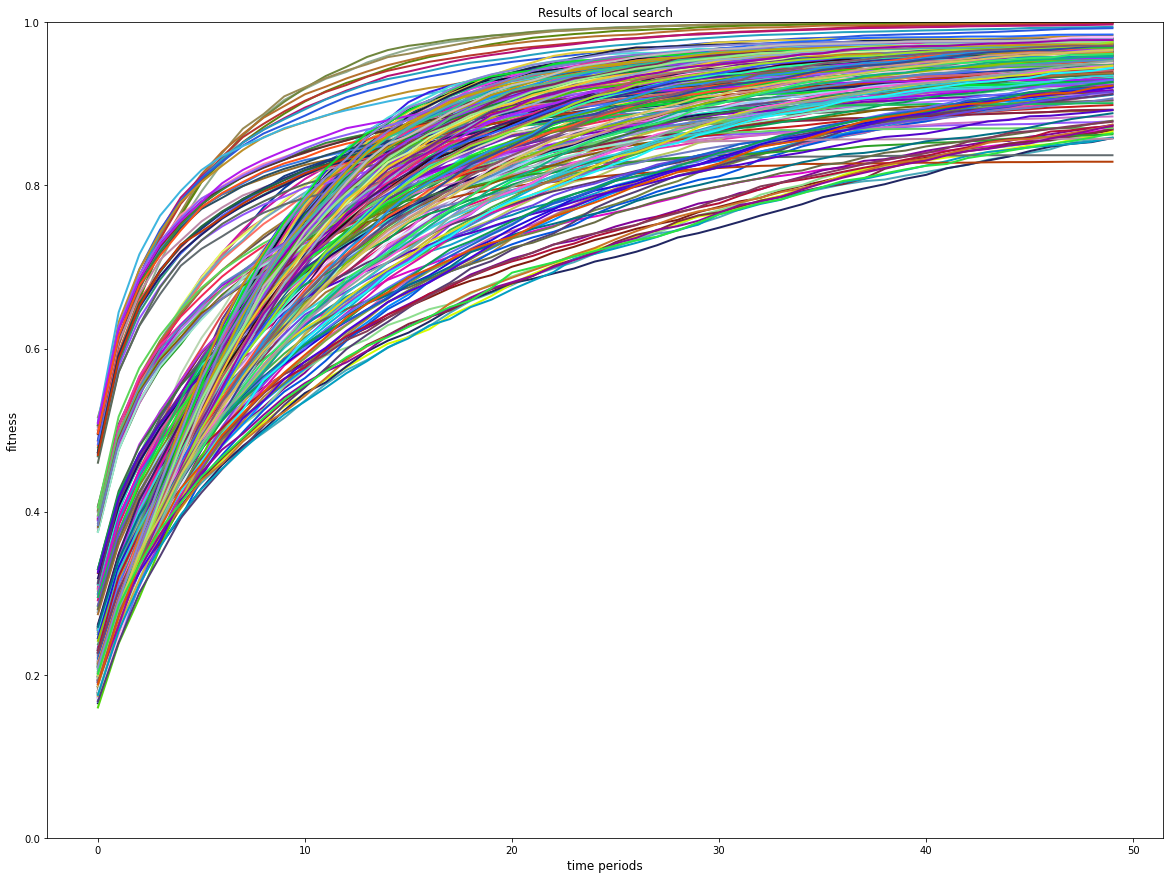

In [21]:
plot_results(results)

In [22]:
print("Done")

Done


In [23]:
def tansform_to_chartjs(results):
    export = {}
    for i,res in enumerate(results):
        export[res["name"]] = {
            "label":res["name"],
            "data":list(res["fitness"]),
            "borderColor": "#"+ ("%06x" % random.randrange(0, 16**6)),
            "backgroundColor": "rgba(0, 0, 0, 0)",
        }
        
    with open('chartjs.json', 'w') as outfile:
        json.dump(export, outfile)    
    
    

In [24]:
tansform_to_chartjs(results)

In [25]:
def run_report(results, N, K, C, p_jumps):
    # reset fitness
    temp_max_fitness = 0
    max_p_jump = 0 
    temp_max_fitness_arr = None
    
    # check max fitness over varying jump probablities
    for p_jump in p_jumps:
        s_name = 'N = 6, K = '+str(K)+', C = '+str(C)+', p_jump = '+str(p_jump)
        for attrs in results:
            if attrs['name'] == s_name:
                search_fitness = np.max(attrs['fitness'])
                if search_fitness >= temp_max_fitness:
                    
                    temp_max_fitness_arr = attrs['fitness']
                    max_p_jump = p_jump
                    temp_max_fitness = search_fitness
    
    print('The maximum fitness under '+ 'N = 6, K = '+str(K)+', C = '+str(C)+' appears for the jump probability '+"{:.1f}".format(max_p_jump)+' and is '+"{:.10f}".format(temp_max_fitness))    
    
    report = {
        "name": generate_title(N, K, C, max_p_jump),
        "N": N,
        "K": K,
        "C": C,
        "max_p_jump": max_p_jump,
        "max_fitness": temp_max_fitness,
        "fitness": temp_max_fitness_arr
    }
    return report

In [26]:
Ks_report = [0,4]
Cs_report = np.arange(0, 1, 0.1).tolist()
Cs_report.append(1)
N = 6
reports = []

for K in Ks_report:
    for C in Cs_report:  
        report = run_report(results=results, N=N, K=K, C=C, p_jumps=p_jumps)
        reports.append(report)
        


The maximum fitness under N = 6, K = 0, C = 0.0 appears for the jump probability 0.1 and is 1.0000000000
The maximum fitness under N = 6, K = 0, C = 0.1 appears for the jump probability 0.4 and is 0.9677645880
The maximum fitness under N = 6, K = 0, C = 0.2 appears for the jump probability 0.6 and is 0.9616840510
The maximum fitness under N = 6, K = 0, C = 0.30000000000000004 appears for the jump probability 0.4 and is 0.9632571013
The maximum fitness under N = 6, K = 0, C = 0.4 appears for the jump probability 0.3 and is 0.9685503205
The maximum fitness under N = 6, K = 0, C = 0.5 appears for the jump probability 0.5 and is 0.9698151152
The maximum fitness under N = 6, K = 0, C = 0.6000000000000001 appears for the jump probability 0.4 and is 0.9749956947
The maximum fitness under N = 6, K = 0, C = 0.7000000000000001 appears for the jump probability 0.5 and is 0.9767089518
The maximum fitness under N = 6, K = 0, C = 0.8 appears for the jump probability 0.4 and is 0.9790493549
The maxim

In [27]:
max_fit_arr = []
for report in reports:
    max_fit_arr.append(report["max_p_jump"]) 

In [28]:
max_fit_arr

[0.1,
 0.4,
 0.6000000000000001,
 0.4,
 0.30000000000000004,
 0.5,
 0.4,
 0.5,
 0.4,
 0.30000000000000004,
 0.4,
 0.9,
 0.7000000000000001,
 0.6000000000000001,
 0.6000000000000001,
 0.6000000000000001,
 0.4,
 0.4,
 0.4,
 0.4,
 0.5,
 0.2]

In [30]:
max_fit_arr_0 = max_fit_arr[0:11]
max_fit_arr_1 = max_fit_arr[11:22]
max_fit_arr_both = [max_fit_arr_0, max_fit_arr_1]
print(max_fit_arr_both)
print(len(max_fit_arr_both[1]))

[[0.1, 0.4, 0.6000000000000001, 0.4, 0.30000000000000004, 0.5, 0.4, 0.5, 0.4, 0.30000000000000004, 0.4], [0.9, 0.7000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.4, 0.4, 0.4, 0.4, 0.5, 0.2]]
11


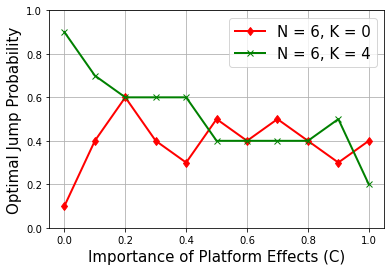

<Figure size 432x288 with 0 Axes>

In [31]:
colors_max_fit = ['r','g']
markers_max_fit = ['d','x'] 
N = 6
Ks = [0,4]
i= 0
for K in Ks:
    plt.plot(Cs, 
             max_fit_arr_both[i], 
             color=colors_max_fit[i], 
             linewidth=2, 
             label='N = '+str(N)+', K = '+str(K),
             marker=markers_max_fit[i],
            )

    i+=1
    
plt.ylim(0, 1)
plt.legend(loc=1,prop={'size':15})
plt.xlabel('Importance of Platform Effects (C)', size=15)
plt.ylabel('Optimal Jump Probability', size=15)
plt.grid(True)
plt.show()
plt.clf()

In [82]:
colors_max_fit = ['r','g']
markers_max_fit = ['d','x'] 

def plot_max_fitness(results):
    """
    plots the maximum fitness over C
    """
    plt.figure(1, facecolor='white', figsize=(20, 15))
    
    n = len(results)
    
    # iterate over the results
    # plot the lines    
    for i, res in enumerate(results):    
        plt.plot(res["C"], res["max_fitness"], 
                 color=colors_max_fit[i], 
                 linewidth=2, 
                 label=generate_title(res["N"], res["K"], res["C"], round(res["max_p_jump"],1)),
                 marker=markers_max_fit[i],
                )
        
        
    plt.ylim(0.7, 1)
    plt.legend(loc=4,prop={'size':15})
    plt.xlabel('C', size=15)
    plt.ylabel('Maximum Fitness', size=15)
    plt.grid(True)
    plt.show()
    plt.clf()

In [62]:
colors = ['r','g','b','c','m','k','tab:purple','tab:olive']
markers = ['d','x','+','H','o','s','|','_'] 

def plot_reports(results):
    """
    plots the results over a time period
    """
    plt.figure(1, facecolor='white', figsize=(20, 15))
    
    n = len(results)
    
    # iterate over the results
    # plot the lines
    for i, res in enumerate(results):    
        plt.plot(res["fitness"], 
                 color=colors[i], 
                 linewidth=2, 
                 label=generate_title(res["N"], res["K"], res["C"], round(res["max_p_jump"],1)),
                 marker=markers[i],
                )
        
        
    plt.ylim(0.1, 1)
    plt.legend(loc=4,prop={'size':15})
    plt.xlabel('Time Periods', size=15)
    plt.ylabel('Perceived Fitness', size=15)
    plt.grid(True)
    plt.show()
    plt.clf()

In [ ]:
plot_reports(reports)